In [16]:
import os
import random

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from numpy import mean
from scipy.stats import sem, t

import model_predict

In [17]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [18]:
num_seqs_to_test = 500
alph = ['A', 'T', 'C', 'G']
max_len = 601
classlabels = [1, 0]

In [19]:
def readfa(filename):
    data,supportNum = [],[]
    with open(filename,'r') as f:
        for line in f:
            line = line.strip('\n')
            if line.startswith('>'):
                x = line.split('|')
                supportNum.append(float(x[1]))
            else:
                seq = line.replace('U', 'T')
                data.append(seq)
    return data,supportNum

In [20]:
p_train_seq,supn_p_train = readfa(f'./data/p_train601.fasta')
n_train_seq,supn_n_train = readfa(f'./data/n_train601.fasta')

p_test_seq,supn_p_test = readfa(f'./data/p_test601.fasta')
n_test_seq,supn_n_test = readfa(f'./data/n_test601.fasta')

seq_train = p_train_seq + n_train_seq
seq_test = p_test_seq + n_test_seq

labels_train = np.concatenate((np.ones((19775, 1)), np.zeros((19775, 1))))
labels_test = np.concatenate((np.ones((4945, 1)), np.zeros((4945, 1))))

all_sequences = seq_train + seq_test
all_labels = np.concatenate((labels_train, labels_test), axis=0)

In [21]:
positive_sequences = [seq for seq, label in zip(all_sequences, all_labels) if label == 1]
negative_sequences = [seq for seq, label in zip(all_sequences, all_labels) if label == 0]

In [22]:
def get_single_bp_mismatches(seq, nucleotides, skip_index=300):
    mismatches = []
    for index, base in enumerate(seq):
        if index == skip_index:
            continue
        
        for alt_base in nucleotides:
            if base != alt_base:
                # 这里使用字符串拼接而不是列表
                new_seq = seq[:index] + alt_base + seq[index+1:]
                mismatches.append(new_seq)
    
    return mismatches

In [23]:
def get_list_of_mismatches_from_list(original_list, nucleotides):
    final_list = []
    for seq in original_list:
        mismatches = get_single_bp_mismatches(seq, nucleotides)
        final_list.extend(mismatches)  # 使用 extend 来添加整个列表的内容
    
    return final_list

In [24]:
def calculate_prediction_differences(mut_preds, origin_preds, num_mutations_per_seq):
    # 确保概率是一维数组
    mut_prob = mut_preds[:, 1].flatten()
    origin_prob = origin_preds[:, 1].flatten()

    # 重复原始概率以匹配突变概率数组的长度
    origin_preds_repeated = np.repeat(origin_prob, num_mutations_per_seq)

    # 计算概率差异
    preds_diff = np.abs(mut_prob - origin_preds_repeated)
    
    return preds_diff

In [25]:
def split_into_buckets(row, num_buckets):
    bucket_size = len(row) // num_buckets
    return [row[i * bucket_size:(i + 1) * bucket_size] for i in range(num_buckets)]

In [26]:
def get_matrix(list_of_seqs, num_seqs_to_test, nucleotides, num_mutations_per_seq=1800, bucket_size=30):
    num_seqs_to_test = min(num_seqs_to_test, len(list_of_seqs))

    select_samples = random.sample(list_of_seqs, num_seqs_to_test)
    
    mismatches = get_list_of_mismatches_from_list(select_samples, alph)
    mut_sequences = [''.join(seq) for seq in mismatches]
    # mismatches 就是把每个位置突变成为另外19种氨基酸

    predictions_mut = model_predict.new_seq_predict(mut_sequences)
    predictions_origin = model_predict.new_seq_predict(select_samples)
    
    proba_diff = calculate_prediction_differences(predictions_mut, predictions_origin, num_mutations_per_seq)

    num_selected_samples = len(select_samples)
    proba_diff = proba_diff.reshape(num_selected_samples, num_mutations_per_seq )
    
    bucketed_diff_list = np.array([split_into_buckets(row, bucket_size) for row in proba_diff])
    
    return bucketed_diff_list

In [27]:
diff_positive = get_matrix(positive_sequences, num_seqs_to_test, alph, 1800, 30)
diff_negative = get_matrix(negative_sequences, num_seqs_to_test, alph, 1800, 30)

pos_data = [np.concatenate(diff_positive[:, i, :]) for i in range(30)]
neg_data = [np.concatenate(diff_negative[:, i, :]) for i in range(30)]

classes = [pos_data, neg_data]

In [28]:
def get_means_and_bounds_of_stds(buckets):
    means = []
    conf_int_lower_bound = []
    conf_int_upper_bound = []

    if len(buckets) != 30:
        raise ValueError("There should be 30 buckets of data.")

    for bucket in buckets:
        confidence = 0.95  # compute 95% confidence interval
        n = len(bucket)
        m = mean(bucket)
        std_err = sem(bucket)
        h = std_err * t.ppf((1 + confidence) / 2, n - 1)
        means.append(m)
        conf_int_lower_bound.append(m - h)
        conf_int_upper_bound.append(m + h)
        
    return [means, conf_int_lower_bound, conf_int_upper_bound]

30
30


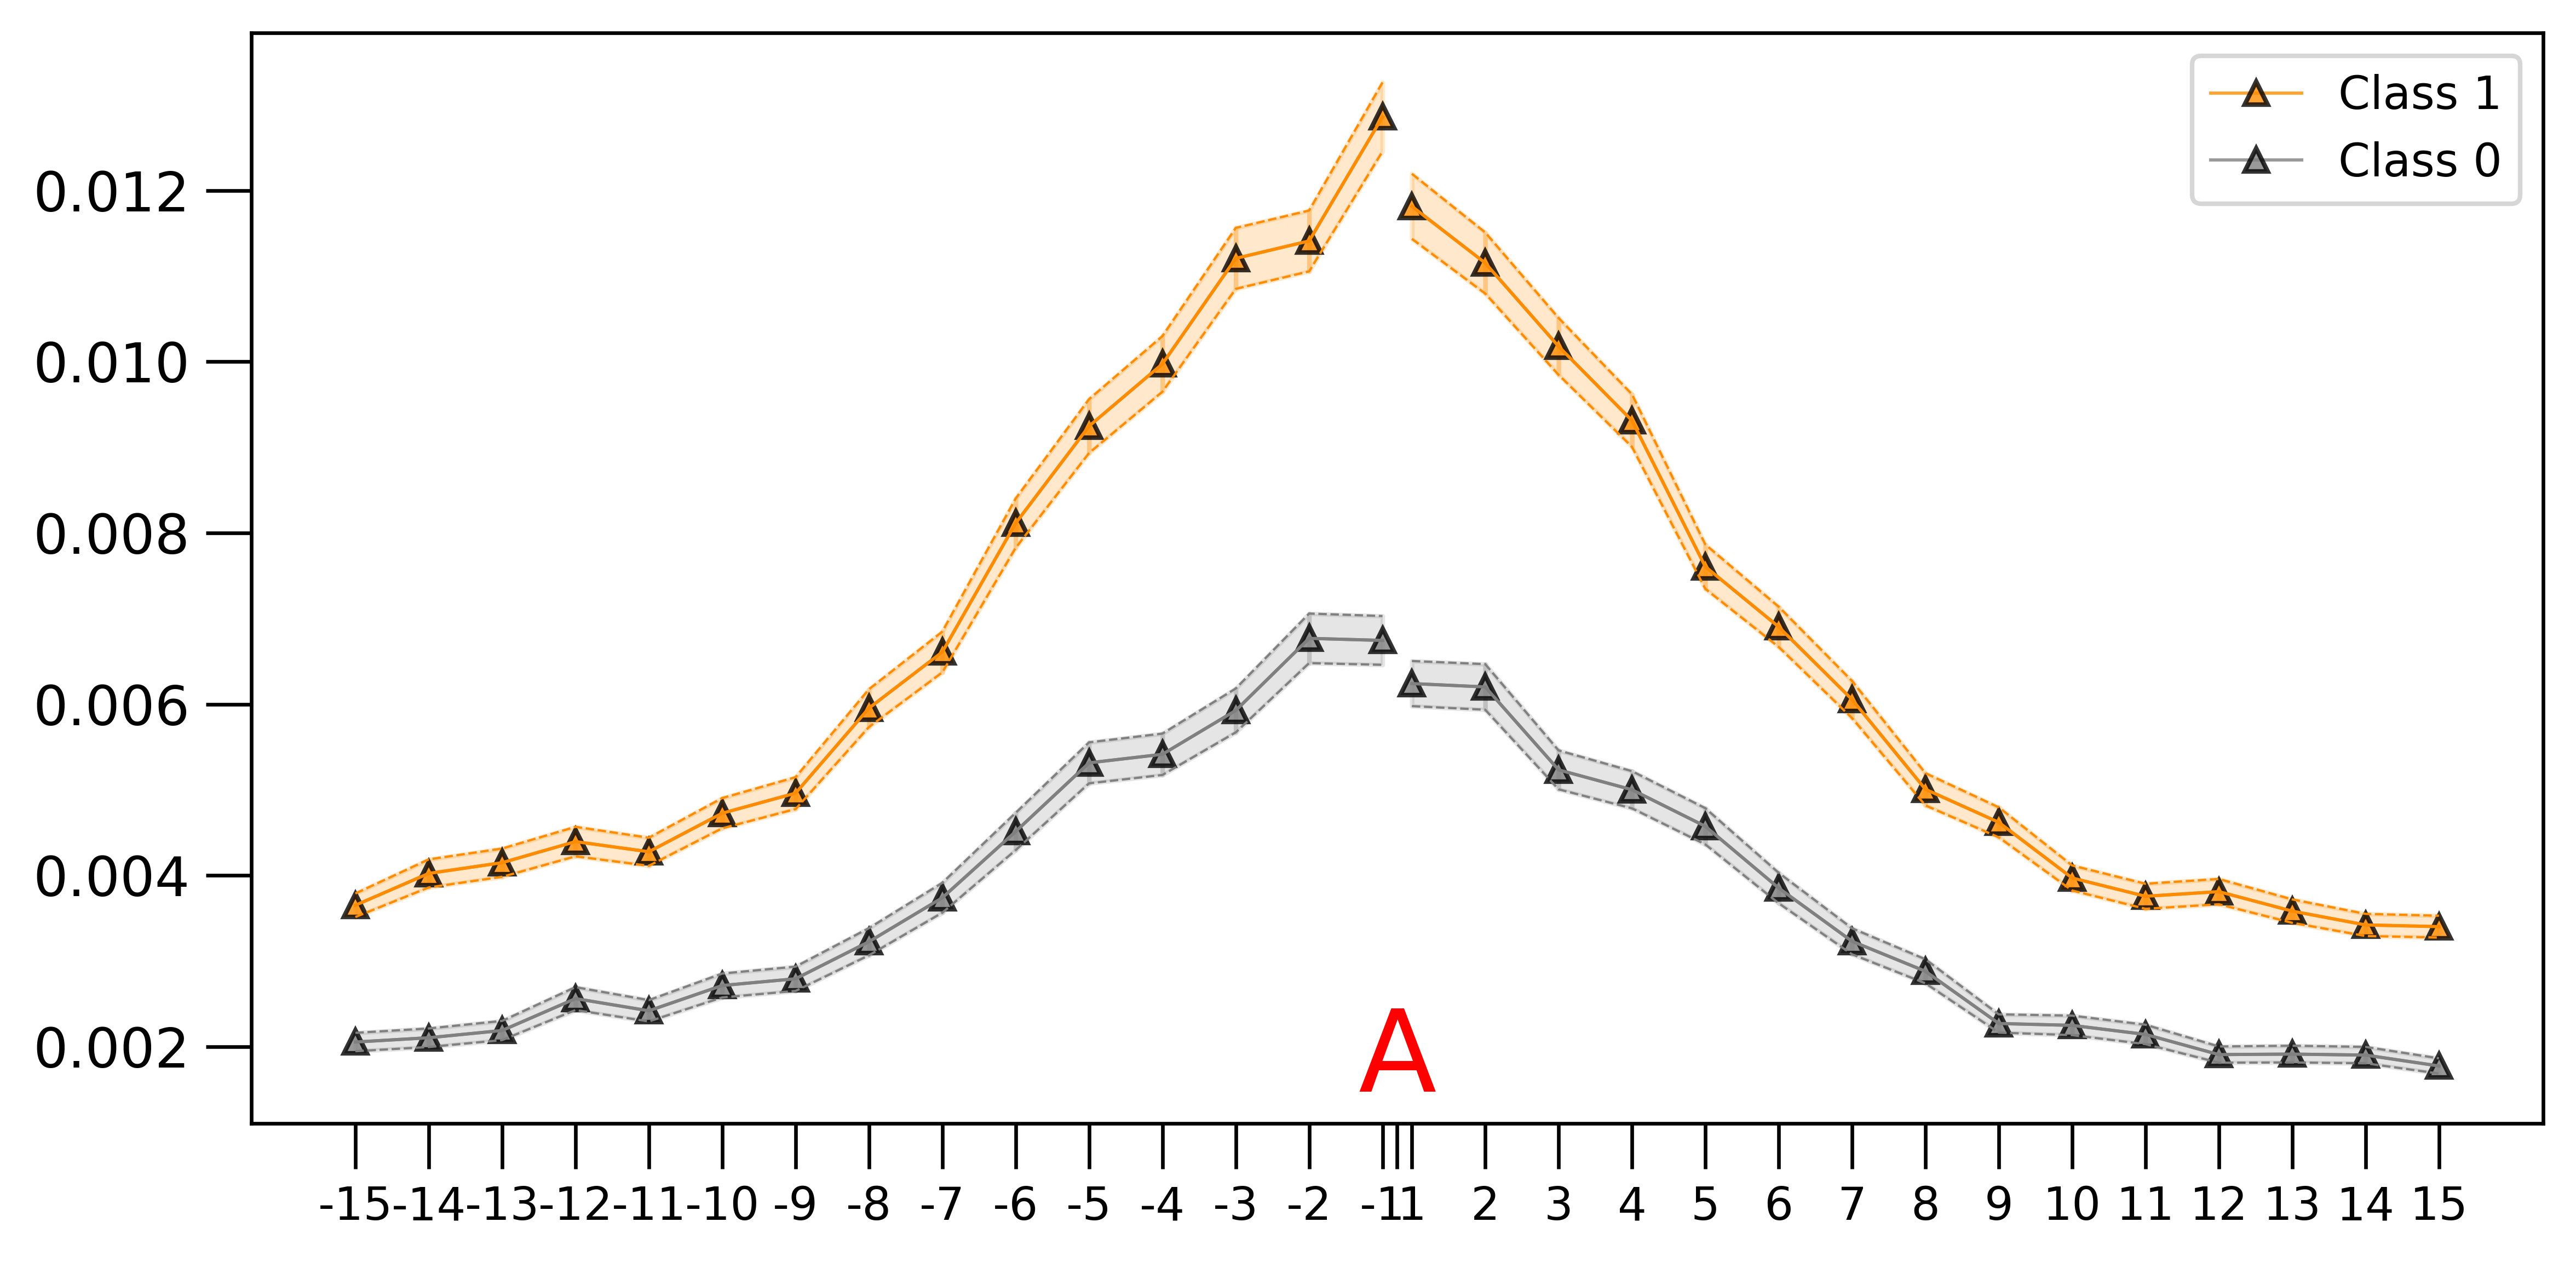

In [29]:
font = {'size': 12}
matplotlib.rc('font', **font)
palette = ['darkorange', 'grey']
fig, ax = plt.subplots(figsize=(8, 4), dpi=600)

# Corrected x-values for a smaller gap in the middle
x_adjusted_corrected = list(range(0, 15)) + [14.2] + list(np.arange(14.4, 29, 1))
index = 0
for classx in classes:
    print(len(classx)) 
    # Getting the means and bounds for each class
    means, conf_int_lower_bound, conf_int_upper_bound = get_means_and_bounds_of_stds(classx)
    
    # Insert a None value, corresponding to the "C" character position, without altering the original lists
    means_with_gap = means[:15] + [None] + means[15:]
    conf_int_lower_bound_with_gap = conf_int_lower_bound[:15] + [None] + conf_int_lower_bound[15:]
    conf_int_upper_bound_with_gap = conf_int_upper_bound[:15] + [None] + conf_int_upper_bound[15:]

    # Plot skipping the blank part
    plt.plot(x_adjusted_corrected, means_with_gap, '^-', color=palette[index % len(palette)], linewidth=0.7,
             label='Class ' + str(int(classlabels[index])), markeredgecolor='black', markersize=5, alpha=0.8)
    plt.plot(x_adjusted_corrected, means_with_gap, '-', color=palette[index % len(palette)], linewidth=0.7)
    plt.plot(x_adjusted_corrected, conf_int_lower_bound_with_gap, '--', linewidth=0.5, color=palette[index % len(palette)])
    plt.plot(x_adjusted_corrected, conf_int_upper_bound_with_gap, '--', linewidth=0.5, color=palette[index % len(palette)])
    
    # Fill between intervals for each range, skipping those with None values
    for i in range(len(x_adjusted_corrected)-1):
        if means_with_gap[i] is not None and means_with_gap[i+1] is not None:
            ax.fill_between([x_adjusted_corrected[i], x_adjusted_corrected[i+1]], 
                            [conf_int_lower_bound_with_gap[i], conf_int_lower_bound_with_gap[i+1]], 
                            [conf_int_upper_bound_with_gap[i], conf_int_upper_bound_with_gap[i+1]], 
                            alpha=0.2, color=palette[index % len(palette)])

    index = index + 1

ax.text(14.2, 0.0012, "A", ha='center', va='bottom', fontsize=25, color='red')

plt.legend(loc="upper right", markerscale=1, fontsize=10)
plt.tick_params(length=10)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks(x_adjusted_corrected)
custom_xticks_labels = [str(-i) for i in range(15, 0, -1)]  + [''] + [str(i) for i in range(1, 16)]
ax.set_xticklabels(custom_xticks_labels, fontsize=10)

ax.spines['right'].set_visible(True)  # Display the right spine
ax.spines['top'].set_visible(True)  

plt.tight_layout()
plt.savefig("combine_ism.svg", dpi=600, bbox_inches='tight')
plt.show()